In [19]:
#importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  learning_curve
from decimal import Decimal
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
#loading dataset
from google.colab import drive
drive.mount('/content/drive/')
df = pd.read_csv('/content/drive/My Drive/MLTechnologies_Course/bioresponse.csv')
df.head()

Mounted at /content/drive/


,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31,D32,D33,D34,D35,D36,D37,D38,D39,...,D1737,D1738,D1739,D1740,D1741,D1742,D1743,D1744,D1745,D1746,D1747,D1748,D1749,D1750,D1751,D1752,D1753,D1754,D1755,D1756,D1757,D1758,D1759,D1760,D1761,D1762,D1763,D1764,D1765,D1766,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,0.243144,0.187856,0.0000,0.000000,0.069000,0.362012,0.301773,0.597930,0.190813,0.107219,0.070500,0.00717,0.137931,1,0.00,0.496683,0.753131,1,1,0.000000,0.262919,0.077200,0.082700,0.200590,0.00000,0.000000,0.0,0.0,0.162383,0.150153,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,0.106480,0.101382,0.1875,0.193548,0.131001,0.350206,0.187419,0.762669,0.180473,0.329962,0.107681,0.01950,0.206897,0,0.75,0.449869,0.720484,0,0,0.666667,0.099400,0.289240,0.216710,0.100295,0.16958,0.235294,0.0,0.0,0.119104,0.075100,...,0,1,1,0,0,0,1,1,0,1,0,0,1,0,1,1,1,0,0,0,1,0,0,0,1,0,1,1,0,0,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,0.352308,0.193548,0.1250,0.000000,0.068900,0.574628,0.283327,0.510633,0.184480,0.073300,0.061600,0.00566,0.000000,1,0.00,0.486610,0.803577,0,1,0.000000,0.428659,0.032400,0.072400,0.000000,0.03930,0.000000,0.0,0.0,0.076100,0.225229,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,0.208989,0.000000,0.0000,0.000000,0.145947,0.584688,0.325247,0.496745,0.242288,0.087700,0.075300,0.01680,0.000000,1,0.00,0.459122,0.829482,0,1,0.000000,0.435410,0.118562,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.068900,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,0.125177,0.532258,0.0000,0.000000,0.094900,0.540323,0.116775,0.552982,0.167897,0.116140,0.054200,0.01350,0.103448,1,0.00,0.381883,0.913374,0,1,0.000000,0.305333,0.054100,0.170822,0.000000,0.00000,0.176471,0.0,0.0,0.019900,0.057400,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
#highlighting predictors X and responses Y="Activity"
y = df["Activity"].values
X = df.drop(["Activity"], axis=1)

In [5]:
#splitting data into train-test subsamples for a subsequent model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
X_train=X_train.values
X_test=X_test.values

In [6]:
# sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1./(1.+np.exp(-z))
    
    return s

In [7]:
# initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros((dim,1))
    b = 0.
    
    return w, b

In [8]:
# propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size which equals the number of features
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
    m = X.shape[1]
    #print('number of objects = ',len(X))
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b )                                 # compute activation
    cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,(A-Y).T)
    db = (1./m)*np.sum(A-Y,axis=1)

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [9]:
# optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, algorithm, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    """
    
    costs = []
    p1=0.9
    p2=0.999
    delta=0.000000001
    v0,s0,wb0=0,0,0
    batch_size=256
    for i in range(num_iterations):
      #Gradient Descent implementation
      if (algorithm=="GD"):
        # Cost and gradient calculation 
        grads, cost = propagate(w,b,X,Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w -=learning_rate*dw
        b -=learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
          costs.append(cost)
      #Stochastic Gradient Descent implementation
      if (algorithm=="SGD"):
        # Cost and gradient calculation
        ind = np.random.choice(len(X),batch_size)
        grads, cost = propagate(w,b,X[:,ind],Y[ind])
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w -=learning_rate*dw
        b -=learning_rate*db       
        
        # Record the costs
        if i % 100 == 0:
          costs.append(cost)
      #ADAM implementation
      if (algorithm=="ADAM"):
        # Cost and gradient calculation
        ind = np.random.choice(len(X),batch_size)
        grads, cost = propagate(w,b,X[:,ind],Y[ind])
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        dwb = np.append(dw.T,db)
        # update rule
        v=p1*v0+(1-p1)*dwb
        v_corr=v/(1-p1**(i+1))
        s=p2*s0+(1-p2)*(dwb**2)
        s_corr=s/(1-p2**(i+1))
        wb=wb0-learning_rate*v_corr/(np.sqrt(s_corr)+delta)
        w=(wb[:len(wb)-1])
        w=w.reshape(len(w),1)
        b=wb[len(wb)-1]
        v0,s0,wb0=v,s,wb
        # Record the costs
        if i % 100 == 0:
          costs.append(cost)
      # Print the cost every 100 training iterations
      if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [10]:
# predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities 
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0,i]<=0.5):
            Y_prediction[0][i]=0
        else:
            Y_prediction[0][i]=1
    
    return Y_prediction

In [11]:
# model

def model(X_train, Y_train, X_test, Y_test, algorithm="GD", num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function we've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array 
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array 
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    algorithm -- algorithm for optimization of logistic regression
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_train.shape[0])

    #optimization step
    parameters, grads, costs = optimize(w, b, X_train, Y_train, algorithm=algorithm, num_iterations=num_iterations, learning_rate=learning_rate, print_cost=print_cost)

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

train accuracy: 57.625311055812304 %
test accuracy: 60.66098081023454 %
train accuracy: 53.288304301457515 %
test accuracy: 57.0362473347548 %
train accuracy: 77.99502310700319 %
test accuracy: 74.73347547974413 %
train accuracy: 67.7568432278706 %
test accuracy: 69.40298507462687 %
train accuracy: 67.543547813722 %
test accuracy: 70.25586353944563 %
train accuracy: 82.26093138997511 %
test accuracy: 76.01279317697228 %
train accuracy: 72.52044081052257 %
test accuracy: 72.70788912579957 %
train accuracy: 71.48951297547103 %
test accuracy: 73.34754797441364 %
train accuracy: 84.07394241023817 %
test accuracy: 74.84008528784648 %
train accuracy: 77.10629221471739 %
test accuracy: 74.73347547974413 %
train accuracy: 76.67970138642019 %
test accuracy: 75.3731343283582 %
train accuracy: 86.66903661571277 %
test accuracy: 73.66737739872069 %
train accuracy: 78.35051546391753 %
test accuracy: 75.5863539445629 %
train accuracy: 77.92392463562034 %
test accuracy: 76.11940298507463 %
train accu

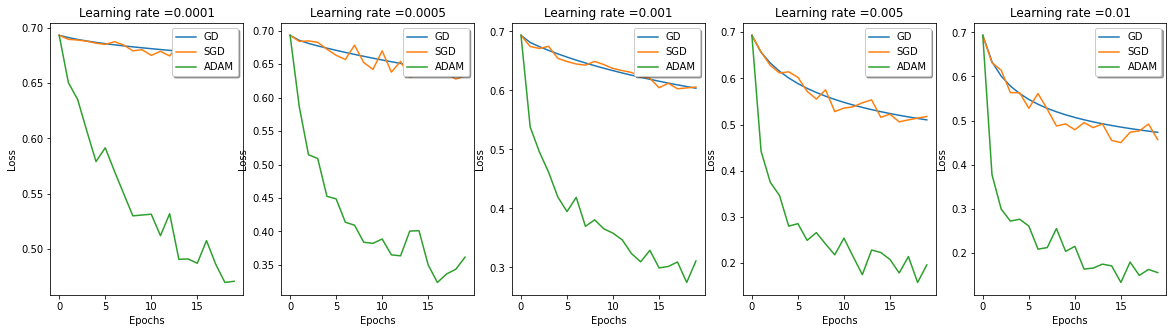

In [ ]:
#learning curves for all 3 optimization algorithms and accuracy of the models depending on learning rate
learning_rates=[0.0001,0.0005,0.001,0.005,0.01]
fig, axs = plt.subplots(1, 5, figsize = (20, 5))
for i,n in enumerate(learning_rates):
    GD=model(X_train.T,y_train.T,X_test.T,y_test.T,algorithm="GD", learning_rate=n)
    SGD=model(X_train.T,y_train.T,X_test.T,y_test.T,algorithm="SGD", learning_rate=n)
    ADAM=model(X_train.T,y_train.T,X_test.T,y_test.T,algorithm="ADAM", learning_rate=n)
    axs[i].plot(GD['costs'] , label='GD')
    axs[i].plot(SGD['costs'] , label='SGD')
    axs[i].plot(ADAM['costs'] , label='ADAM')
    axs[i].set_xlabel("Epochs")
    axs[i].set_ylabel("Loss")
    axs[i].set_title("Learning rate ="+str(n))
    axs[i].legend(shadow=True, loc=1)

The graphs show a few things:
1. The less learning rate the more iterations should be carried out in order to converge to the minimum
2. ADAM algorithm performs better in terms of convergence rate then GD and SGD due to the combination of ideas of modified SGD. Stochastic gradient descent with batch size=256 and these learning rates perform approximately as simple gradient descent.
3. SGD and ADAM are represented by polylines because of batching while GD looks smooth since the gradients are calculated using all dataset.


> The accuracy shows some tendency too:


1. ADAM shows better train accuracy than GD and SGD but with growth of learning rate test accuracy becomes approximately equal to those of other models. For GD and SGD with growth of learning rate the train/test accuracy increases since they make a larger step in the direction of minimum. So for each model we need to select individially the step_size(learning rate) in order to fast and correctly converge to the minimum.